<a href="https://colab.research.google.com/github/hey-sid29/Scratch_Linear_Model_and_Neural_network/blob/main/2_Frameworks_and_basic_ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frameworks and Basic Ensembling:<br>
In this notebook, I used fast.ai to show the pros of using a framework, as in the previous notebook, when we made linear models and simple neural network from scratch, I ended up focusing too much on the mathematical intuitions of how a model works.
<br>
this notebook also contains, how ensembling works.[a basic display of ensembling(ensembling algorithms include: XGBoost, LightGBM, RandomForest, CatBoost, AdaBoost etc)]

In [1]:
!mkdir ~/.kaggle


In [2]:
!mv /content/kaggle.json ~/.kaggle/kaggle.json

## 1. Using Fast.ai:


In [3]:
#Downloading dataset from kaggle:

from pathlib import Path
import os

is_kag = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kag:
  path = Path('../input/titanic')
  !pip install -Uqq fastai

else:
  import zipfile, kaggle
  path = Path('titanic')
  if not path.exists():
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)



100%|██████████| 34.1k/34.1k [00:00<00:00, 28.6MB/s]

In [4]:
#using the fastai tabular library
from fastai.tabular.all import *

#setting default display options:
pd.options.display.float_format = '{:.2f}'.format
set_seed(330)

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


#### Feature Engineering:

In [9]:
def added_features(df):
  df['LogFare'] = np.log1p(df['Fare']) #1. Converting the Fare Values into Log values of fare. [LogFare = log(1+Fare)]
  df['Deck'] = df.Cabin.str[0].map(dict(A='ABC', B='ABC', C='ABC', D='DE', E='DE', F='FG', G='FG')) #2. A feature that records the Deck of the Cabin
  df['Family'] = df.SibSp + df.Parch #3. Creating a feature that contains (Total family)
  df['Alone'] = df.Family==0 #4. a feature which will record passengers with no family members
  df['TicketFrequency'] = df.groupby('Ticket')['Ticket'].transform('count') #5. a feature which counts the frequency of the ticket in dataset
  df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]
  df['Title'] = df.Title.map(dict(Mr='Mr', Miss='Miss', Mrs='Mrs', Master='Master')) #6.A feature that records only the Title used in names


In [10]:
added_features(df)

In [11]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFrequency,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,True,1,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q,2.25,NaN,0,True,1,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S,3.97,DE,0,True,1,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S,3.09,NaN,4,False,4,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S,2.50,NaN,2,False,3,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C,3.44,NaN,1,False,2,Mrs


#### Splitting Data & Creating a Tabular Dataloader:

In [12]:
#Splitting the dataset into training and validation:
splits = RandomSplitter(seed=330)(df)


In [13]:
#??TabularPandas

In [16]:
#Creating a tabular dataloader:
tab_dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFrequency', 'Family'],
    y_names='Survived', y_block=CategoryBlock()
).dataloaders(path='.')

#### Training the Model:

In [23]:
learner = tabular_learner(tab_dls, metrics=accuracy, layers=[20, 20, 20, 10])

SuggestedLRs(slide=0.10000000149011612, valley=0.013182567432522774)

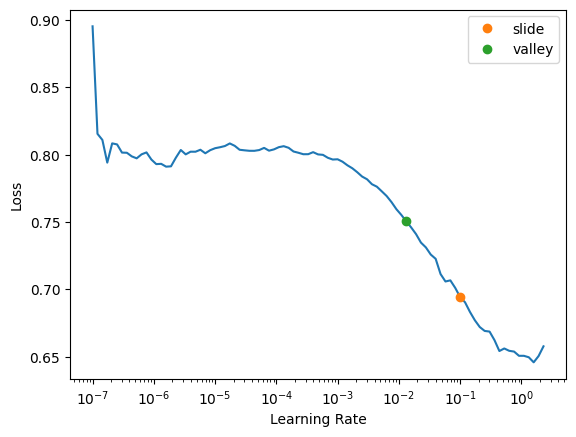

In [24]:
#finding optimal learning rates:
learner.lr_find(suggest_funcs=(slide, valley))

In [28]:
learner.fit(8, lr=0.06)

epoch,train_loss,valid_loss,accuracy,time
0,0.355727,0.354172,0.870786,00:00
1,0.349544,0.358317,0.876405,00:00
2,0.347872,0.392790,0.853933,00:00
3,0.353927,0.379218,0.865169,00:00
4,0.350665,0.377374,0.859551,00:00
5,0.350820,0.379875,0.842697,00:00
6,0.348121,0.386926,0.859551,00:00
7,0.341697,0.349491,0.876405,00:00


### Running the model on Test Data:

In [29]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
added_features(tst_df)

##Basic Preprocessing and dataloading


In [31]:
tst_dls = learner.dls.test_dl(tst_df)

In [32]:
predictions, _ = learner.get_preds(dl=tst_dls)

In [33]:
tst_df['Survived'] = (predictions[:,1]>0.5).int()
submit = tst_df[['PassengerId', 'Survived']]
submit.to_csv('submit.csv', index=False)

## Basic Ensembling Models:

**Ensembling**: is a technique used in ML, that suggests creation of multiple models, which are trained on different subsets of the original dataset, then taking an average of their results.

In [34]:
def create_EnsembleModel():
  learner = tabular_learner(tab_dls, metrics=accuracy, layers=[20, 30, 10])
  with learner.no_bar(), learner.no_logging():
    learner.fit(8, lr=0.06)
  return learner.get_preds(dl=tst_dls)[0]


In [35]:
learns = [create_EnsembleModel() for _ in range(5)]

In [36]:
ensemble_preds = torch.stack(learns).mean(0)

In [37]:
ensemble_preds

tensor([[0.8710, 0.1290],
        [0.5780, 0.4220],
        [0.8927, 0.1073],
        [0.8717, 0.1283],
        [0.3822, 0.6178],
        [0.8587, 0.1413],
        [0.3576, 0.6424],
        [0.8909, 0.1091],
        [0.3046, 0.6954],
        [0.8709, 0.1291],
        [0.9101, 0.0899],
        [0.7459, 0.2541],
        [0.0322, 0.9678],
        [0.8715, 0.1285],
        [0.0188, 0.9812],
        [0.0462, 0.9538],
        [0.8541, 0.1459],
        [0.7742, 0.2258],
        [0.5497, 0.4503],
        [0.4697, 0.5303],
        [0.7119, 0.2881],
        [0.2434, 0.7566],
        [0.0526, 0.9474],
        [0.6229, 0.3771],
        [0.0550, 0.9450],
        [0.8773, 0.1227],
        [0.0162, 0.9838],
        [0.7798, 0.2202],
        [0.6501, 0.3499],
        [0.8370, 0.1630],
        [0.8874, 0.1126],
        [0.9034, 0.0966],
        [0.4926, 0.5074],
        [0.4965, 0.5035],
        [0.6351, 0.3649],
        [0.7642, 0.2358],
        [0.4502, 0.5498],
        [0.4564, 0.5436],
        [0.8

In [38]:
#Creating a submission_df:
tst_df['Survived'] = (ensemble_preds[:,1]>0.5).int()
submit = tst_df[['PassengerId', 'Survived']]
submit.to_csv('submission.csv', index=False)